In [ ]:
#-------------------------------------# # Library importations # #-------------------------------------#

In [2]:
.libPaths("/usr/local/lib/R/site-library") # You need to run this line if you are using Jupyter server
library(stringr) 
library(jsonlite)
library(plyr)
library(lubridate)
library(parallel)
library(rpart)



ERROR: Error in library(stringr): Package ‘stringr’ version 1.2.0 cannot be unloaded


In [3]:
library(xgboost)

In [4]:
library(foreach)
library(randomForest)

randomForest 4.6-12
Type rfNews() to see new features/changes/bug fixes.


In [5]:
library(doSNOW)
library(foreach)
library(parallel)

# Set up your multiple cores as separate workers and then make them a cluster.
workers <- detectCores()
workers # How many cores do you have?
cluster <- makeCluster(workers, type = "SOCK")
registerDoSNOW(cluster)

Loading required package: iterators
Loading required package: snow

Attaching package: ‘parallel’

The following objects are masked from ‘package:snow’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, clusterSplit, makeCluster, parApply,
    parCapply, parLapply, parRapply, parSapply, splitIndices,
    stopCluster



[1] 8

In [ ]:
################################### SECTION 3: PREPARE THE DATA  ###########################################

In [6]:
# Load in the training set.
train.df <- read.csv("data analytics 2 twitter_train_allVariables.csv")
train.df[1,]

X1,author_id,created_at,retweets_nr,reply_nr,like_nr,quote_nr,mentions_usernames,id,text,⋯,reply_settings,hour,month,day,year,textCleanLem,Score,Handle_Count,Hashtag_Count,avg_score
0,20123238,2020-07-27 13:50:12,0,0,0,0,"'BottleRockNapa', 'JaMCellars', 'ElleKingMusic'",1.287747e+18,@BottleRockNapa @JaMCellars @ElleKingMusic Why did you cut Santana down to a 2 song set (slight exaggeration)? At least Muse didn't get edited.,⋯,everyone,13,7,27,2020,jamcellars ellekingmusic cut santana song set slight exaggeration least muse get edited,0,3,0,5.205714


In [7]:
head(train.df)

X1,author_id,created_at,retweets_nr,reply_nr,like_nr,quote_nr,mentions_usernames,id,text,⋯,reply_settings,hour,month,day,year,textCleanLem,Score,Handle_Count,Hashtag_Count,avg_score
0,2.012324e+07,2020-07-27 13:50:12,0,0,0,0,"'BottleRockNapa', 'JaMCellars', 'ElleKingMusic'",1.287747e+18,@BottleRockNapa @JaMCellars @ElleKingMusic Why did you cut Santana down to a 2 song set (slight exaggeration)? At least Muse didn't get edited.,⋯,everyone,13,7,27,2020,jamcellars ellekingmusic cut santana song set slight exaggeration least muse get edited,0,3,0,5.205714
1,2.358610e+09,2020-07-25 21:07:09,0,0,1,0,"'BottleRockNapa', 'JaMCellars', 'ElleKingMusic'",1.287132e+18,@BottleRockNapa @JaMCellars @ElleKingMusic I was there her set was peppered with some heavy rockabilly vibes fantastic,⋯,everyone,21,7,25,2020,jamcellars ellekingmusic set peppered heavy rockabilly vibe fantastic,1,3,0,5.870000
2,5.931166e+07,2020-07-25 19:30:00,0,0,1,0,"'wearetwinxl', 'BottleRockNapa', 'CameronWalker'",1.287108e+18,INTERVIEW: Twin XL (@wearetwinxl) rides 'Good' vibes all the way to a new act for its career musicians. Will they play @BottleRockNapa next May? | @CameronWalker ✏: me https://t.co/vzwVk2aIQx,⋯,everyone,19,7,25,2020,interview twin xl wearetwinxl ride good vibe way new act career musician play next may cameronwalker,1,3,0,6.201538
3,1.044741e+18,2020-07-25 17:56:38,0,0,0,0,"'BottleRockNapa', 'ChiliPeppers'",1.287084e+18,@BottleRockNapa @ChiliPeppers Talento BRASILEIRO...♥️🎶 https://t.co/iKDy7JwN57,⋯,everyone,17,7,25,2020,chilipeppers talento brasileiro,0,2,0,6.243247
4,1.760610e+07,2020-07-25 05:30:49,0,0,1,0,"'BottleRockNapa', 'NRateliff', 'SantanaCarlos'",1.286897e+18,@BottleRockNapa @NRateliff @SantanaCarlos Loved it! ❤,⋯,everyone,5,7,25,2020,nrateliff santanacarlos loved,1,3,0,7.960000
5,7.685055e+08,2020-07-25 04:37:25,0,1,1,0,"'BottleRockNapa', 'LiveNation'",1.286883e+18,@BottleRockNapa So sad to see this end. Has been a weekly positive end to many stressful work weeks. I have enjoyed my favorites and new fan to several groups. @LiveNation I hope we can continue this in some other format. Music uplifts the soul during these dark hours. Thanks to all the artists!,⋯,everyone,4,7,25,2020,sad see end weekly positive end many stressful work week enjoyed favorite new fan several group livenation hope continue format music uplift soul dark hour thanks artist,2,2,0,5.952500


In [ ]:
# 3.3. Data Splitting

In [9]:

# Split data.
set.seed(201) 
small.train.df <- train.df[sample(nrow(train.df), 0.75 * nrow(train.df)) ,]
valid.df <- train.df[-as.numeric(row.names(small.train.df)), ]


In [10]:
# Pull apart the Xs and Ys into separate frames.
xtrain <- small.train.df[ , -c(4,5,6,7,19)]
xvalid <- valid.df[ , -c(4,5,6,7,19)]
ytrain <- small.train.df[ , 19]
yvalid <- valid.df[ , 19]


In [11]:

# Highly skewed data
summary(train.df$Score)


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  0.000   0.000   0.000   1.065   1.000 102.000 

In [12]:

# Calculate the percentage of the tweets that have 0 retweets.
length(which(train.df$Score == 0))/length(train.df$Score)


[1] 0.7180952

In [ ]:
# create the test set

In [1]:
# Option 1:
xtest_1 <- data.frame(hour=21,month=8,Handle_Count=6,Hashtag_Count=1,avg_score=5.896) #good+bad

# Option 2:
xtest_2 <- data.frame(hour=14,month=7,Handle_Count=6,Hashtag_Count=1,avg_score=5.896) #good+good

# Option 3:
xtest_3 <- data.frame(hour=21,month=8,Handle_Count=2,Hashtag_Count=2,avg_score=6.011 ) #bad+bad

# Option 4:
xtest_4 <- data.frame(hour=14,month=7,Handle_Count=2,Hashtag_Count=2,avg_score=6.011 )#bad + good

In [2]:
xtest <- rbind(xtest_1, xtest_2, xtest_3, xtest_4)
xtest

hour,month,Handle_Count,Hashtag_Count,avg_score
21,8,6,1,5.896
14,7,6,1,5.896
21,8,2,2,6.011
14,7,2,2,6.011


In [ ]:
################################### SECTION 4: PREDICTION MODELS ###########################################

In [ ]:
# Root Mean Squared Logarithmic Error (RMSLE)
RMSLE <- function(predictions, realizations){
    sqrt(sum((log(predictions+1) - log(realizations+1))^2)/length(predictions))
}

In [13]:
# 4.1. Linear Regression
# Select variables.
# hour, month, handle_count, hashtag_count, happines_score
variablesSelected <- c(10,11,15,16,17)  

In [14]:
# Fit the linear regression
lm.1 <- lm(log(1 + ytrain) ~ ., data = xtrain[, variablesSelected])
summary(lm.1)


Call:
lm(formula = log(1 + ytrain) ~ ., data = xtrain[, variablesSelected])

Residuals:
    Min      1Q  Median      3Q     Max 
-0.9406 -0.2445 -0.1758  0.0919  3.8302 

Coefficients:
               Estimate Std. Error t value Pr(>|t|)    
(Intercept)    0.194189   0.481704   0.403 0.687076    
hour           0.007405   0.004157   1.781 0.075662 .  
month          0.033873   0.008803   3.848 0.000139 ***
Handle_Count   0.027636   0.011280   2.450 0.014726 *  
Hashtag_Count -0.071340   0.017699  -4.031  6.7e-05 ***
avg_score     -0.022806   0.077524  -0.294 0.768775    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.5658 on 387 degrees of freedom
Multiple R-squared:  0.1241,	Adjusted R-squared:  0.1128 
F-statistic: 10.97 on 5 and 387 DF,  p-value: 6.923e-10


In [15]:
lm.1.pred <- predict(lm.1, xvalid)

lm.1.pred.unlogged <- exp(lm.1.pred) - 1  # Unlog the y variable.
RMSLE(lm.1.pred.unlogged, yvalid)  #Score the lm model.

[1] 0.5974126

In [16]:

# The code below saves the results in a data frame model.results so that 
# we can show and compare the error rates for all the models later.

model.results <- data.frame(RMSLE=0.597412612110352, Model="linear_regression1")


In [17]:
# Fit the linear regression with interaction
lm.2 <- lm(log(1 + ytrain) ~ . + .^2, data = xtrain[, variablesSelected])
summary(lm.2)



Call:
lm(formula = log(1 + ytrain) ~ . + .^2, data = xtrain[, variablesSelected])

Residuals:
    Min      1Q  Median      3Q     Max 
-0.9345 -0.1823 -0.1584  0.0713  3.8547 

Coefficients:
                            Estimate Std. Error t value Pr(>|t|)   
(Intercept)                -0.369329   1.535120  -0.241  0.81001   
hour                       -0.068520   0.067091  -1.021  0.30777   
month                       0.441676   0.154278   2.863  0.00443 **
Handle_Count               -0.532607   0.179109  -2.974  0.00313 **
Hashtag_Count              -0.309340   0.293503  -1.054  0.29258   
avg_score                   0.038319   0.250366   0.153  0.87844   
hour:month                  0.001298   0.001231   1.055  0.29232   
hour:Handle_Count           0.001588   0.001765   0.900  0.36886   
hour:Hashtag_Count         -0.004808   0.002733  -1.759  0.07935 . 
hour:avg_score              0.011553   0.010945   1.056  0.29186   
month:Handle_Count         -0.006717   0.003103  -2.165  0.0

In [18]:
lm.2.pred <- predict(lm.2, xvalid)
lm.2.pred.unlogged <- exp(lm.2.pred) - 1  # Unlog the y variable.
RMSLE(lm.2.pred.unlogged, yvalid)  #Score the lm model.

[1] 0.5869695

In [19]:
# Save the results for later ...

model.results <- rbind(model.results, data.frame( RMSLE = 0.58696948184094, Model="linear_regression_interaction"))

In [ ]:
# 4.2. XGBoost

In [20]:
# Create matrix for xgboost.
xtrain.xgb <- model.matrix(~ 0 + ., data = xtrain[, variablesSelected])
xvalid.xgb <- model.matrix(~ 0 + ., data = xvalid[, variablesSelected])

# Fit the xgboost model
model.xgb <- xgboost(xtrain.xgb, log(ytrain+1), nround = 50, verbose = 0, nthred = workers)  #nround=50 (0.556433932153292), 
                                                                                                    #=100(0.557719466805755)
                                                                                            #=75 (0.557078972676131)
                                                                               #=40  (0.55689691697435)

# Generate predictions
xgb.pred <- predict(model.xgb, xvalid.xgb)
xgb.pred.unlogged <- exp(xgb.pred) - 1  # Unlog the y variable.

# Score the predictions.
RMSLE(xgb.pred.unlogged, yvalid)  #Score the model.

[1] 0.5564339

In [21]:
# Save the results for later ...

model.results <- rbind(model.results, data.frame( RMSLE = 0.556433932153292, Model="xgboost1"))

In [22]:
# Print out the variale importance
xgb.importance(colnames(xtrain[, variablesSelected]), model.xgb)
colnames(xtrain.xgb)

Feature,Gain,Cover,Frequency
avg_score,0.46013526,0.51770550,0.34021305
hour,0.20192999,0.21578368,0.30559254
Handle_Count,0.16077300,0.11037577,0.11984021
month,0.11511404,0.10524461,0.17376831
Hashtag_Count,0.06204771,0.05089043,0.06058589


[1] "hour"          "month"         "Handle_Count"  "Hashtag_Count"
[5] "avg_score"

In [23]:
xtrain.xgb

,hour,month,Handle_Count,Hashtag_Count,avg_score
322,8,12,1,2,6.417143
88,19,8,1,4,6.608333
192,13,9,2,4,6.593333
21,8,7,2,0,6.372500
328,13,12,4,0,5.247273
73,19,8,1,4,6.608333
24,19,7,1,1,6.095000
191,16,9,2,4,6.593333
52,23,8,2,4,6.593333
149,1,9,2,4,6.593333


In [24]:
# Fit the xgboost model
model2.xgb <- xgboost(xtrain.xgb[,-4], log(ytrain+1), nround = 50, verbose = 0, nthred = workers)

# Generate predictions
xgb.pred <- predict(model2.xgb, xvalid.xgb[,-4])
xgb.pred.unlogged2 <- exp(xgb.pred) - 1  # Unlog the y variable.

# Score the predictions.
RMSLE(xgb.pred.unlogged2, yvalid)  #Score the model.

[1] 0.5669623

In [25]:
# Save the results for later ...

model.results <- rbind(model.results, data.frame( RMSLE = 0.566962307748351, Model="xgboost2"))

In [26]:
model.results

RMSLE,Model
0.5974126,linear_regression1
0.5869695,linear_regression_interaction
0.5564339,xgboost1
0.5669623,xgboost2


In [27]:

# Select variables.
# hour, month, handle_count, happines_score
variablesSelected <- c(10,11,15,17)  

In [28]:
# Print out the variale importance
xgb.importance(colnames(xtrain[, variablesSelected]), model2.xgb)
colnames(xtrain.xgb)

Feature,Gain,Cover,Frequency
avg_score,0.5147359,0.58782161,0.3941411
hour,0.2000775,0.22754857,0.3069241
Handle_Count,0.1730727,0.08824770,0.1111851
month,0.1121139,0.09638212,0.1877497


[1] "hour"          "month"         "Handle_Count"  "Hashtag_Count"
[5] "avg_score"

In [29]:
# Fit the xgboost model
model3.xgb <- xgboost(xtrain.xgb[,-c(2,4)], log(ytrain+1), nround = 50, verbose = 0, nthred = workers)

# Generate predictions
xgb.pred <- predict(model3.xgb, xvalid.xgb[,-c(2,4)])
xgb.pred.unlogged3 <- exp(xgb.pred) - 1  # Unlog the y variable.

# Score the predictions.
RMSLE(xgb.pred.unlogged3, yvalid)  #Score the model.

[1] 0.5701218

In [30]:
# Save the results for later ...

model.results <- rbind(model.results, data.frame( RMSLE = 0.57012181459039, Model="xgboost3"))

In [31]:
#the error is higher so I will not cut other variables

In [ ]:
# 4.3. Random forest

In [32]:
# Select variables.
# hour, month, handle_count, hashtag_count, happines_score
variablesSelected <- c(10,11,15,16,17)  

In [33]:
dim(xtrain)

[1] 393  17

In [34]:
model.rf <- foreach(ntreePerWorker = rep(ceiling(500/workers), workers), .combine=combine, .multicombine=TRUE, .inorder=FALSE, .packages = c("randomForest")) %dopar% {
  randomForest(xtrain[, variablesSelected], log(ytrain+1), ntree = ntreePerWorker, mtry = 3,  importance = TRUE,set.seed(202, "L'Ecuyer"))
}

# Generate predictions
rf.pred <- predict(model.rf, xvalid[, variablesSelected])
rf.pred.unlogged <- exp(rf.pred) - 1  # Unlog the y variable.

# Score the predictions.
RMSLE(rf.pred.unlogged, yvalid)  #Score the model.

[1] 0.535697

In [35]:
model.rf2 <- foreach(ntreePerWorker = rep(ceiling(500/workers), workers), .combine=combine, .multicombine=TRUE, .inorder=FALSE, .packages = c("randomForest")) %dopar% {
  randomForest(xtrain[, variablesSelected], log(ytrain+1), ntree = ntreePerWorker, mtry = 2, importance = TRUE,set.seed(202, "L'Ecuyer"))
}

# Generate predictions
rf.pred <- predict(model.rf2, xvalid[, variablesSelected])
rf.pred.unlogged <- exp(rf.pred) - 1  # Unlog the y variable.

# Score the predictions.
RMSLE(rf.pred.unlogged, yvalid)  #Score the model.

[1] 0.5342046

In [36]:
# Save the results for later ...

model.results <- rbind(model.results, data.frame( RMSLE = 0.535697017933687, Model="rf1"))
model.results <- rbind(model.results, data.frame( RMSLE = 0.534204606275396, Model="rf2"))

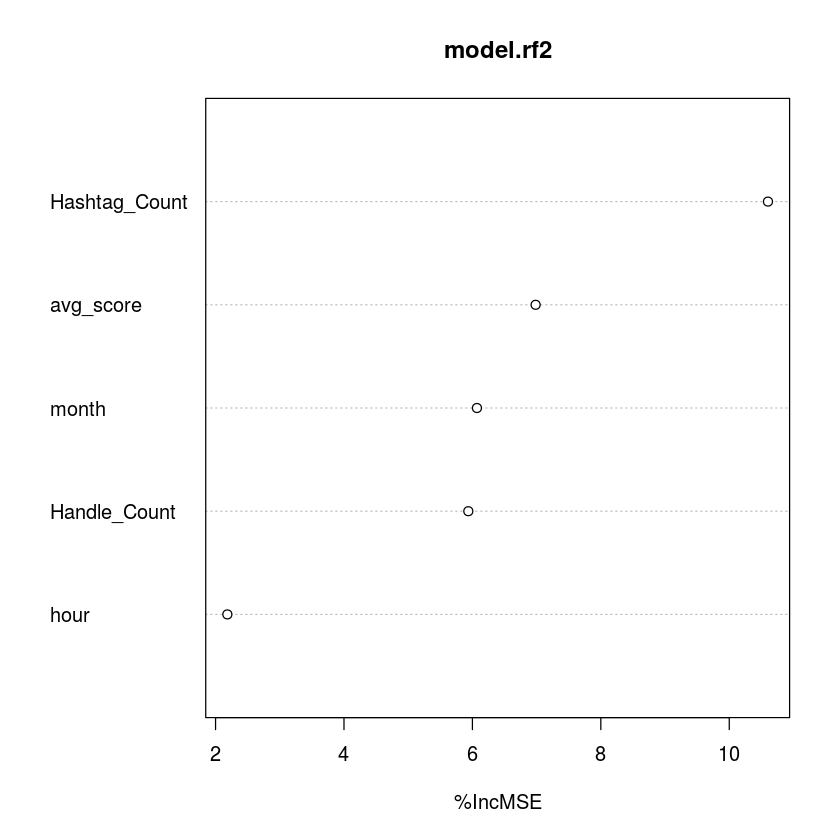

In [37]:
#variable importance
varImpPlot(model.rf2, type = 1)

In [38]:
# Select variables.
#  month, handle_count, hashtag_count, happines_score
variablesSelected <- c(11,15,16,17)  

In [39]:
model.rf3 <- foreach(ntreePerWorker = rep(ceiling(500/workers), workers), .combine=combine, .multicombine=TRUE, .inorder=FALSE, .packages = c("randomForest")) %dopar% {
  randomForest(xtrain[, variablesSelected], log(ytrain+1), ntree = ntreePerWorker, mtry = 2,  importance = TRUE,set.seed(202, "L'Ecuyer"))
}

# Generate predictions
rf.pred <- predict(model.rf3, xvalid[, variablesSelected])
rf.pred.unlogged3 <- exp(rf.pred) - 1  # Unlog the y variable.

# Score the predictions.
RMSLE(rf.pred.unlogged3, yvalid)  #Score the model.

[1] 0.5643846

In [40]:
# Save the results for later ...

model.results <- rbind(model.results, data.frame( RMSLE =0.564384590477743 , Model="rf3"))

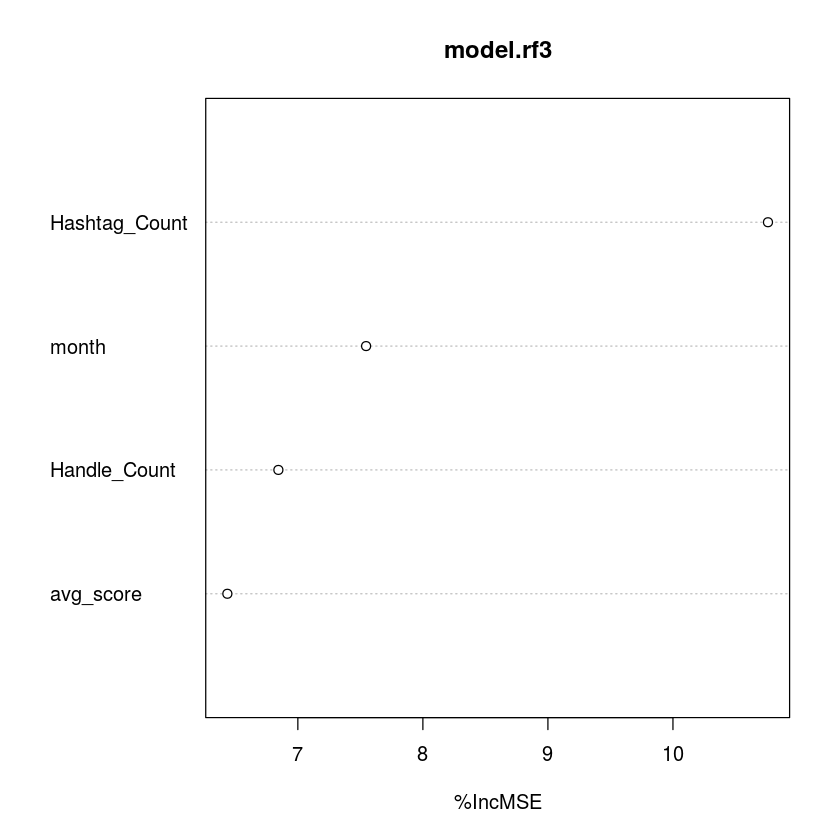

In [41]:
#variable importance
varImpPlot(model.rf3, type = 1)

In [42]:
# Select variables.
#  month, handle_count, hashtag_count
variablesSelected <- c(11,15,16)  

In [43]:
model.rf3 <- foreach(ntreePerWorker = rep(ceiling(500/workers), workers), .combine=combine, .multicombine=TRUE, .inorder=FALSE, .packages = c("randomForest")) %dopar% {
  randomForest(xtrain[, variablesSelected], log(ytrain+1), ntree = ntreePerWorker, mtry = 3,  importance = TRUE,set.seed(202, "L'Ecuyer"))
}

# Generate predictions
rf.pred <- predict(model.rf3, xvalid[, variablesSelected])
rf.pred.unlogged3 <- exp(rf.pred) - 1  # Unlog the y variable.

# Score the predictions.
RMSLE(rf.pred.unlogged3, yvalid)  #Score the model.

[1] 0.5441818

In [44]:
# Save the results for later ...

model.results <- rbind(model.results, data.frame( RMSLE =0.544181843634976 , Model="rf3"))

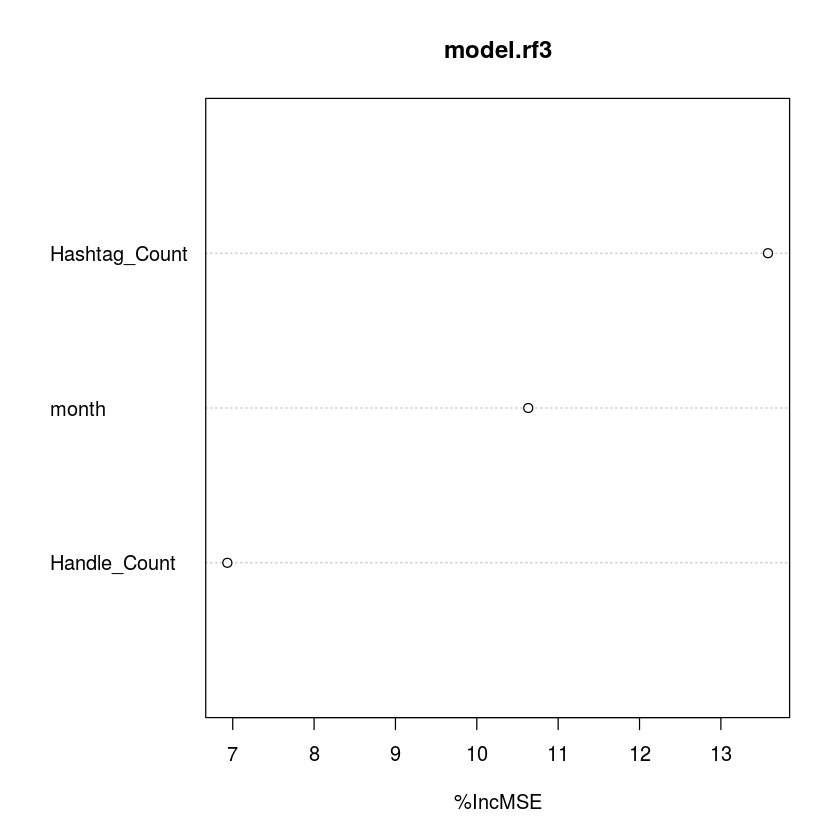

In [45]:
#variable importance
varImpPlot(model.rf3, type = 1)

In [46]:
# Select variables.
#  month,  hashtag_count
variablesSelected <- c(11,16)  

In [47]:
model.rf4 <- foreach(ntreePerWorker = rep(ceiling(500/workers), workers), .combine=combine, .multicombine=TRUE, .inorder=FALSE, .packages = c("randomForest")) %dopar% {
  randomForest(xtrain[, variablesSelected], log(ytrain+1), ntree = ntreePerWorker, mtry = 2,  importance = TRUE,set.seed(202, "L'Ecuyer"))
}

# Generate predictions
rf.pred <- predict(model.rf4, xvalid[, variablesSelected])
rf.pred.unlogged4 <- exp(rf.pred) - 1  # Unlog the y variable.

# Score the predictions.
RMSLE(rf.pred.unlogged4, yvalid)  #Score the model.

[1] 0.5630676

In [48]:
# Save the results for later ...

model.results <- rbind(model.results, data.frame( RMSLE =0.5630676447418, Model="rf4"))

In [49]:
#the error is higher so I will not cut other variables

In [ ]:
# 4.4. Regression Tree

In [50]:
# Select variables.
# hour, month, handle_count, hashtag_count, happines_score
variablesSelected <- c(10,11,15,16,17)  

In [51]:
# Fit the regression tree.
model.rpart <- rpart(log(ytrain+1) ~., data = xtrain[, variablesSelected], control = rpart.control(cp = 0.001))

# Generate predictions
rpart.pred <- predict(model.rpart, xvalid[, variablesSelected])
rpart.pred.unlogged <- exp(rpart.pred) - 1  # Unlog the y variable.

# Score the predictions.
RMSLE(rpart.pred.unlogged, yvalid)  #Score the model.

[1] 0.6227337

In [52]:
# Save the results for later ...

model.results <- rbind(model.results, data.frame( RMSLE =0.622733749382179, Model="rtree1"))

In [53]:
# Which attributes are most important?
model.rpart$variable.importance

avg_score  Handle_Count         month          hour Hashtag_Count 
    38.916578     20.182371     11.587419     11.221777      4.987692

In [54]:
# Select variables.
# hour, month, handle_count, happines_score
variablesSelected <- c(10,11,15,17)  

In [55]:
# Fit the regression tree.
model.rpart2 <- rpart(log(ytrain+1) ~., data = xtrain[, variablesSelected], control = rpart.control(cp = 0.001))

# Generate predictions
rpart.pred <- predict(model.rpart2, xvalid[, variablesSelected])
rpart.pred.unlogged2<- exp(rpart.pred) - 1  # Unlog the y variable.

# Score the predictions.
RMSLE(rpart.pred.unlogged2, yvalid)  #Score the model.

[1] 0.6227337

In [56]:
# Save the results for later ...

model.results <- rbind(model.results, data.frame( RMSLE =0.622733749382179, Model="rtree2"))

In [57]:
# Which attributes are most important?
model.rpart2$variable.importance

avg_score Handle_Count        month         hour 
    38.91658     20.18237     11.58742     11.22178

In [58]:
# Select variables.
# month, handle_count, happines_score
variablesSelected <- c(11,15,17)  

In [59]:
# Fit the regression tree.
model.rpart3 <- rpart(log(ytrain+1) ~., data = xtrain[, variablesSelected], control = rpart.control(cp = 0.001))

# Generate predictions
rpart.pred <- predict(model.rpart3, xvalid[, variablesSelected])
rpart.pred.unlogged <- exp(rpart.pred) - 1  # Unlog the y variable.

# Score the predictions.
RMSLE(rpart.pred.unlogged, yvalid)  #Score the model.

[1] 0.6316206

In [60]:
# Save the results for later ...

model.results <- rbind(model.results, data.frame( RMSLE =0.631620557932791, Model="rtree3"))

In [61]:
#the error is higher so I will not cut other variables

In [62]:
model.results

RMSLE,Model
0.5974126,linear_regression1
0.5869695,linear_regression_interaction
0.5564339,xgboost1
0.5669623,xgboost2
0.5701218,xgboost3
0.5356970,rf1
0.5342046,rf2
0.5643846,rf3
0.5441818,rf3
0.5630676,rf4


In [ ]:
# 4.5.1. Simple average models

In [63]:
# Ensemble model.
ensemble_pred_avg <- ( rf.pred.unlogged+xgb.pred.unlogged+lm.2.pred.unlogged+rpart.pred.unlogged2)/4
RMSLE(ensemble_pred_avg, valid.df$Score) 

[1] 0.5550108

In [101]:
# Save the results for later ...

model.results <- rbind(model.results, data.frame( RMSLE =0.555010811744055, Model="avg_1"))

In [64]:
# Ensemble model.
ensemble_pred_avg2 <- ( rf.pred.unlogged+xgb.pred.unlogged+lm.2.pred.unlogged)/3
RMSLE(ensemble_pred_avg2, valid.df$Score) 

[1] 0.5385909

In [102]:
# Save the results for later ...

model.results <- rbind(model.results, data.frame( RMSLE =0.538590894737329, Model="avg_2"))

In [65]:
# Ensemble model.
ensemble_pred_avg3 <- ( rf.pred.unlogged+xgb.pred.unlogged)/2
RMSLE(ensemble_pred_avg3, valid.df$Score) 

[1] 0.5374305

In [103]:
# Save the results for later ...

model.results <- rbind(model.results, data.frame( RMSLE =0.537430513260946, Model="avg_3"))

In [ ]:
# 4.5.2. Weighted Average

In [88]:
m1_weight <- seq(0.1,0.9,0.1)
m2_weight <- seq(0.1,0.9,0.1)

# set up a matrix to store the RMSLE errors
RMSLE_matrix <- matrix(0,9,9)
for (i in 1:9) {
    for (j in 1:9){
        if (m2_weight[j]+ m1_weight[i] > 1) next
        ensemble_pred <- m1_weight[i]*rf.pred.unlogged +xgb.pred.unlogged*m2_weight[j] + lm.2.pred.unlogged*(1-
                                                                                        m1_weight[i] - m2_weight[i])
        RMSLE_matrix[i,j] <- RMSLE(ensemble_pred, valid.df$Score)
    }
}

Warning message in log(predictions + 1):
“NaNs produced”Warning message in log(predictions + 1):
“NaNs produced”Warning message in log(predictions + 1):
“NaNs produced”

In [89]:
RMSLE_matrix

0.5637825,0.5572505,0.5545717,0.5546927,0.5569155,0.5607490,0.5658334,0.5718968,0.5787302
0.5558011,0.5491001,0.5462316,0.5461753,0.5482454,0.5519540,0.5569406,0.5629313,0.0000000
0.5508474,0.5436868,0.5403838,0.5399393,0.5416724,0.5450942,0.5498401,0.0000000,0.0000000
0.5495987,0.5416530,0.5376345,0.5365543,0.5377310,0.5406701,0.0000000,0.0000000,0.0000000
0.5534752,0.5443029,0.5391811,0.5371199,0.5374305,0.0000000,0.0000000,0.0000000,0.0000000
0.5664573,0.5551486,0.5481305,0.5443909,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000
0.6287228,0.6012818,0.5843025,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000
NaN,NaN,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000
NaN,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000


In [90]:
ensemble_pred<-m1_weight[8]*rf.pred.unlogged +xgb.pred.unlogged*m2_weight[1] + lm.2.pred.unlogged*(1-m1_weight[8] - m2_weight[1])

In [91]:
RMSLE_matrix[8,1] <- RMSLE(ensemble_pred, valid.df$Score)

In [92]:
RMSLE_matrix[8,1]

[1] 0.5337317

In [93]:
ensemble_pred<-m1_weight[8]*rf.pred.unlogged +xgb.pred.unlogged*m2_weight[2] + lm.2.pred.unlogged*(1-m1_weight[8] - m2_weight[2])

In [94]:
RMSLE_matrix[8,2]<- RMSLE(ensemble_pred, valid.df$Score)

In [95]:
RMSLE_matrix[8,2]

[1] 0.5331524

In [96]:
ensemble_pred<-m1_weight[9]*rf.pred.unlogged +xgb.pred.unlogged*m2_weight[1] + lm.2.pred.unlogged*(1-m1_weight[9] - m2_weight[1])

In [97]:
RMSLE_matrix[9,1]<- RMSLE(ensemble_pred, valid.df$Score)

In [98]:
RMSLE_matrix[9,1]

[1] 0.5332131

In [99]:
RMSLE_matrix

0.5637825,0.5572505,0.5545717,0.5546927,0.5569155,0.5607490,0.5658334,0.5718968,0.5787302
0.5558011,0.5491001,0.5462316,0.5461753,0.5482454,0.5519540,0.5569406,0.5629313,0.0000000
0.5508474,0.5436868,0.5403838,0.5399393,0.5416724,0.5450942,0.5498401,0.0000000,0.0000000
0.5495987,0.5416530,0.5376345,0.5365543,0.5377310,0.5406701,0.0000000,0.0000000,0.0000000
0.5534752,0.5443029,0.5391811,0.5371199,0.5374305,0.0000000,0.0000000,0.0000000,0.0000000
0.5664573,0.5551486,0.5481305,0.5443909,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000
0.6287228,0.6012818,0.5843025,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000
0.5337317,0.5331524,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000
0.5332131,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000


In [100]:
# Find the element in the matrix corresponds to the lowest error?
which(RMSLE_matrix == min(RMSLE_matrix[RMSLE_matrix>0]), arr.ind = TRUE) 


row,col
8,2


In [ ]:
# According to the table, the weights put on the predictions from the random forest, 
# xgboost and linear regression should be 0.8,0.2,and 0. 
# The lowest RMSLE erros acheived by the weighted average ensemble is 0.5331524.

In [104]:
# Save the results for later ...

model.results <- rbind(model.results, data.frame( RMSLE =0.5331524, Model="weighted_avg"))

In [105]:
model.results

RMSLE,Model
0.5974126,linear_regression1
0.5869695,linear_regression_interaction
0.5564339,xgboost1
0.5669623,xgboost2
0.5701218,xgboost3
0.5356970,rf1
0.5342046,rf2
0.5643846,rf3
0.5441818,rf3
0.5630676,rf4


In [ ]:
# 4.6. Best prediction model 

In [85]:
#train the best model on the whole dataset

In [106]:
# Pull apart the Xs and Ys into separate frames.
xtrainf <- train.df[ , -c(4,5,6,7,19)]
ytrainf <- train.df[ , 19]


In [107]:

# Select variables.
# hour, month, handle_count, hashtag_count, happines_score
variablesSelected <- c(10,11,15,16,17)  

In [108]:

# Create matrix for xgboost.
xtrain.xgb <- model.matrix(~ 0 + ., data = xtrainf[, variablesSelected])


# Fit the xgboost model
model.xgb <- xgboost(xtrain.xgb, log(ytrainf+1), nround = 50, verbose = 0, nthred = workers)  #nround=50 (0.556433932153292), 
                                                                                                    #=100(0.557719466805755)
                                                                                            #=75 (0.557078972676131)
                                                                               #=40  (0.55689691697435)

# Fit the random forest

model.rf2 <- foreach(ntreePerWorker = rep(ceiling(500/workers), workers), .combine=combine, .multicombine=TRUE, .inorder=FALSE, .packages = c("randomForest")) %dopar% {
  randomForest(xtrainf[, variablesSelected], log(ytrainf+1), ntree = ntreePerWorker, mtry = 2, importance = TRUE,set.seed(202, "L'Ecuyer"))
}


In [111]:

#xgboost1

xtrain.xgb <- model.matrix(~ 0 + ., data = xtest)

# Generate predictions
xgb.pred <- predict(model.xgb, xtrain.xgb)
xgb.pred.unlogged_test <- exp(xgb.pred) - 1  # Unlog the y variable.


#random forest 2
# Generate predictions
rf.pred <- predict(model.rf2, xtest)
rf.pred.unlogged_test <- exp(rf.pred) - 1  # Unlog the y variable.



In [112]:
ensemble_pred<-0.8*rf.pred.unlogged_test +xgb.pred.unlogged_test*0.2 

In [113]:
ensemble_pred

1        2        3        4 
2.554789 5.462227 1.479470 1.375764